In [11]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr

In [2]:
# read data
df_gps = pd.read_excel("Data_Radiosonde/GpsResults.xlsx")
df_altitude = pd.read_csv("Data_WXT/20250827_altitude_kite_from_wxt.csv")

file_path = "Data_Theodolite/TheoRot_20250827_150544.txt"
date_str = "2025-08-27"
start_time_theo = pd.to_datetime(date_str + " 09:08:09")  # times in df_wxt are UTC + 1

# Read all lines first
with open(file_path, "r") as f:
    lines = f.readlines()
# Skip last three lines
lines = lines[:-3]
# Lists to store data
time_sec = []
value1 = []
value2 = []

for line in lines:
    line = line.strip()
    if line.startswith("D"):  # data line
        parts = line.split()
        time_sec.append(float(parts[1]))
        value1.append(float(parts[2]))
        value2.append(float(parts[3]))
    elif line.startswith("S"):
        print("Metadata:", line)  # optional

azimuth = np.array(value1) + (231.1-123.93)
azimuth[azimuth > 360] = azimuth[azimuth > 360] - 360
# Create DataFrame
df_theo = pd.DataFrame({
    "time_sec": [start_time_theo + timedelta(seconds=s) for s in time_sec],
    "azimuth": azimuth,
    "elevation": value2})

Metadata: S 25/08/27 09:08:09


In [3]:
# calculate values per minute
df_gps['Time'] = pd.to_datetime(df_gps['Time'][1:])

# 'time' als Index setzen
df_gps = df_gps.set_index('Time')

# Mittelwert pro Minute berechnen
df_min_lat = df_gps['Latitude'][1:].resample('1T').mean().reset_index()
df_min_lon = df_gps['Longitude'][1:].resample('1T').mean().reset_index()

/var/folders/k6/y7fg0_p51yj9myt7l79bb1mc0000gn/T/ipykernel_47113/2820643715.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_min_lat = df_gps['Latitude'][1:].resample('1T').mean().reset_index()
/var/folders/k6/y7fg0_p51yj9myt7l79bb1mc0000gn/T/ipykernel_47113/2820643715.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_min_lon = df_gps['Longitude'][1:].resample('1T').mean().reset_index()


In [4]:
# location of the kite attachment
lat_kite = 54.528697
lon_kite = 11.060892

In [5]:
def distance_m(lat1, lon1, lat2 = lat_kite, lon2 = lon_kite):
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Umrechnung in Meter (numpy-Version)
    lat_m = dlat * 111320
    lon_m = dlon * 111320 * np.cos(np.radians(lat1))

    # Euklidische Distanz
    distance = np.sqrt(lat_m**2 + lon_m**2)
    return distance

In [6]:
start_time = df_altitude['time'][0]
end_time = df_altitude['time'].iloc[-1]
mask = (df_min_lat['Time'] >= start_time) & (df_min_lat['Time'] <= end_time)
df_lat_filtered = df_min_lat.loc[mask]
df_lon_filtered = df_min_lon.loc[mask]

In [7]:
hor_dist = distance_m(np.float64(df_lat_filtered['Latitude']), np.float64(df_lon_filtered['Longitude']))

In [1]:
df_lat_filtered['Latitude']

NameError: name 'df_lat_filtered' is not defined

In [8]:
elevation_angle = np.arctan(df_altitude['altitude'] / hor_dist)
elevation_angle = np.rad2deg(elevation_angle)

In [9]:
df_altitude['time'][1]

'2025-08-27 08:52:00'

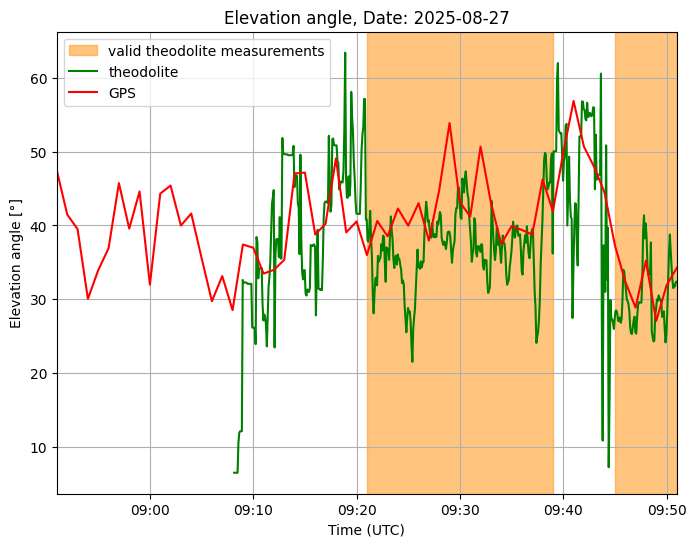

In [10]:
valid1 = datetime(2025, 8, 27, 9, 21, 0)  # 2025-08-27 11:21:00
valid2 = datetime(2025, 8, 27, 9, 39, 0)  # 2025-08-27 11:39:00
valid3 = datetime(2025, 8, 27, 9, 45, 0)
valid4 = datetime(2025, 8, 27, 9, 51, 0)

df_altitude['time'] = pd.to_datetime(df_altitude['time'], format="%Y-%m-%d %H:%M:%S")

fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.axvspan(valid1,valid2, color='darkorange', alpha=0.5, label='valid theodolite measurements')
ax2.axvspan(valid3,valid4, color='darkorange', alpha=0.5)
ax2.plot(df_theo['time_sec'], df_theo['elevation'], color="green",label='theodolite')
ax2.plot(df_altitude['time'], elevation_angle, color="red",label='GPS')
ax2.set_xlabel("Time (UTC)")
ax2.set_ylabel("Elevation angle [°]")
ax2.set_title("Elevation angle, Date: 2025-08-27")
ax2.set_xlim(df_altitude['time'][0], df_altitude['time'].iloc[-1])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.legend()
ax2.grid(True)

fig.savefig('Plots/20250827_Elevation_angle_GPS.png', dpi=300)

In [16]:
# load Lidar data
ds = xr.open_dataset("Data_Lidar/20250827_080000.nc")
df_Lidar_08 = ds.to_dataframe().reset_index()

In [18]:
ds

<xarray.Dataset> Size: 120kB
Dimensions:              (time: 127, height: 14)
Coordinates:
  * height               (height) float32 56B 7.0 10.0 15.0 ... 180.0 200.0
  * time                 (time) datetime64[ns] 1kB 2025-08-27T08:00:17.325639...
Data variables: (12/22)
    time_coverage_start  |S128 128B b'2025-08-27T08:00:17Z'
    time_coverage_end    |S128 128B b'2025-08-27T08:59:50Z'
    instrument_type      |S128 128B b'lidar'
    platform_type        |S128 128B b'fixed'
    time_reference       |S128 128B b'1970-01-01T00:00:00Z'
    lat                  (time) float32 508B 54.53 54.53 54.53 ... 54.53 54.53
    ...                   ...
    MSE                  (time, height) float64 14kB 0.04049 0.4854 ... 0.02128
    VALID                (time, height) float64 14kB 1.0 0.9931 ... 0.9693
    MDT                  (time, height) float64 14kB 7.989 9.904 ... 182.0 206.8
    SNR                  (time, height) float64 14kB -15.91 -15.34 ... -14.74
    SPW                  (time, height) float64 14kB 2.79 4.228 ... 13.17 16.34
    QUALITY              (time, height) uint8 2kB 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes:
    Conventions:       CF-1.7
    title:             METEK LiDAR Profile Data
    institution:       University of Innsbruck, ACINN
    references:        
    source:            
    history:           
    comment:           Hochhaeuser
    instrument_name:   WindRanger16
    firmware_version:  0.9.34
    site_name:         Hochhaeuser
    field_names:       VEL,DIR,U,V,W,MSE,VALID,MDT,SNR,SPW,QUALITY